In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, plot_roc_curve, auc, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from xgboost import XGBClassifier,plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,KFold


sns.set_style('whitegrid')

In [10]:
df_train = pd.read_csv("aug_train.csv")
df_test = pd.read_csv("aug_test.csv")

In [11]:
y = df_train[df_train['target'] == 1]
y['company_type'].unique()

array([nan, 'Pvt Ltd', 'Funded Startup', 'Early Stage Startup',
       'Public Sector', 'NGO', 'Other'], dtype=object)

In [12]:
total = df_train.shape[0]
job_change = df_train[df_train['target'] == 1].shape[0]
job_change/total

0.24934753105752167

In [13]:
df_train.shape

(19158, 14)

In [14]:
df_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


In [17]:
df_test['target'] = -1 #remeber that we have to drop this column later

df_pre = pd.concat([df_train, df_test], axis = 0).reset_index(drop = True)

In [18]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  object 
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  object 
 4   relevent_experience     21287 non-null  object 
 5   enrolled_university     20870 non-null  object 
 6   education_level         20775 non-null  object 
 7   major_discipline        18162 non-null  object 
 8   experience              21217 non-null  object 
 9   company_size            14727 non-null  object 
 10  company_type            14513 non-null  object 
 11  last_new_job            20824 non-null  object 
 12  training_hours          21287 non-null  int64  
 13  target                  21287 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [19]:
from sklearn.preprocessing import LabelEncoder

#Making Copy of data just for example
df_lb = df_pre.copy()
df_lb['education_level'].value_counts()

Graduate          12867
Masters            4857
High School        2239
Phd                 468
Primary School      344
Name: education_level, dtype: int64

In [21]:
#Fill nan values
df_lb.loc[:, "education_level"] = df_lb['education_level'].fillna("NONE")

In [22]:
# initialize LabelEncoder
lbl_enc = LabelEncoder()

# fit label encoder and transform values on ord_2 column
df_lb.loc[:, "education_level"] = lbl_enc.fit_transform(df_lb['education_level'].values)

df_lb['education_level'].value_counts()

0    12867
2     4857
1     2239
3      512
4      468
5      344
Name: education_level, dtype: int64

In [24]:

gender_map = {
        'Female': 2,
        'Male': 1,
        'Other': 0
         }

relevent_experience_map = {
    'Has relevent experience':  1,
    'No relevent experience':    0
}

enrolled_university_map = {
    'no_enrollment'   :  0,
    'Full time course':    1, 
    'Part time course':    2 
}
education_level_map = {
    'Primary School' :    0,
    'Graduate'       :    2,
    'Masters'        :    3, 
    'High School'    :    1, 
    'Phd'            :    4
    } 
    
major_map ={ 
    'STEM'                   :    0,
    'Business Degree'        :    1, 
    'Arts'                   :    2, 
    'Humanities'             :    3, 
    'No Major'               :    4, 
    'Other'                  :    5 
}
experience_map = {
    '<1'      :    0,
    '1'       :    1, 
    '2'       :    2, 
    '3'       :    3, 
    '4'       :    4, 
    '5'       :    5,
    '6'       :    6,
    '7'       :    7,
    '8'       :    8, 
    '9'       :    9, 
    '10'      :    10, 
    '11'      :    11,
    '12'      :    12,
    '13'      :    13, 
    '14'      :    14, 
    '15'      :    15, 
    '16'      :    16,
    '17'      :    17,
    '18'      :    18,
    '19'      :    19, 
    '20'      :    20, 
    '>20'     :    21
} 
company_type_map = {
    'Pvt Ltd'               :    0,
    'Funded Startup'        :    1, 
    'Early Stage Startup'   :    2, 
    'Other'                 :    3, 
    'Public Sector'         :    4, 
    'NGO'                   :    5
}

company_size_map = {
    '<10'          :    0,
    '10/49'        :    1, 
    '100-500'      :    2, 
    '1000-4999'    :    3, 
    '10000+'       :    4, 
    '50-99'        :    5, 
    '500-999'      :    6, 
    '5000-9999'    :    7
}
last_new_job_map = {
    'never'        :    0,
    '1'            :    1, 
    '2'            :    2, 
    '3'            :    3, 
    '4'            :    4, 
    '>4'           :    5
}

In [25]:

df_pre.loc[:,'education_level'] = df_pre['education_level'].map(education_level_map)
df_pre.loc[:,'company_size'] = df_pre['company_size'].map(company_size_map)
df_pre.loc[:,'company_type'] = df_pre['company_type'].map(company_type_map)
df_pre.loc[:,'last_new_job'] = df_pre['last_new_job'].map(last_new_job_map)
df_pre.loc[:,'major_discipline'] = df_pre['major_discipline'].map(major_map)
df_pre.loc[:,'enrolled_university'] = df_pre['enrolled_university'].map(enrolled_university_map)
df_pre.loc[:,'relevent_experience'] = df_pre['relevent_experience'].map(relevent_experience_map)
df_pre.loc[:,'gender'] = df_pre['gender'].map(gender_map)
df_pre.loc[:,'experience'] = df_pre['experience'].map(experience_map)

#encoding city feature using label encoder
lb_en = LabelEncoder()

df_pre.loc[:,'city'] = lb_en.fit_transform(df_pre.loc[:,'city']) 

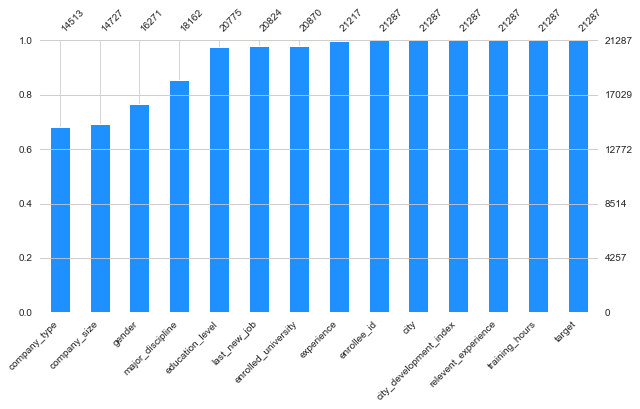

In [26]:
missingno.bar(df_pre,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=10);

In [27]:

for col in df_pre.columns:
    null_val = df_pre[col].isnull().sum()
    null_prec = (null_val * 100) / df_pre.shape[0]
    print('> %s , Missing: %d (%.1f%%)' % (col, null_val, null_prec))

> enrollee_id , Missing: 0 (0.0%)
> city , Missing: 0 (0.0%)
> city_development_index , Missing: 0 (0.0%)
> gender , Missing: 5016 (23.6%)
> relevent_experience , Missing: 0 (0.0%)
> enrolled_university , Missing: 417 (2.0%)
> education_level , Missing: 512 (2.4%)
> major_discipline , Missing: 3125 (14.7%)
> experience , Missing: 70 (0.3%)
> company_size , Missing: 6560 (30.8%)
> company_type , Missing: 6774 (31.8%)
> last_new_job , Missing: 463 (2.2%)
> training_hours , Missing: 0 (0.0%)
> target , Missing: 0 (0.0%)


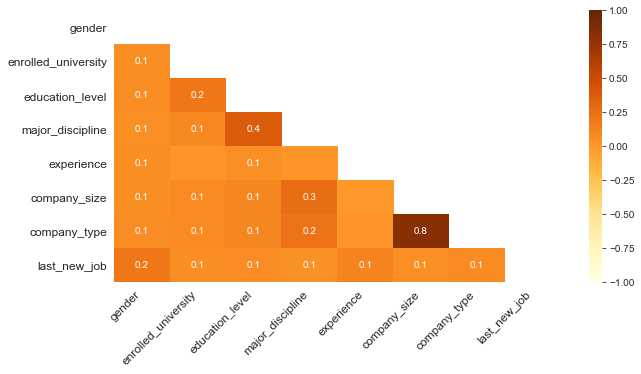

In [28]:
missingno.heatmap(df_pre, cmap="YlOrBr", figsize=(10,5), fontsize=12);

In [29]:
df_pre1 = df_pre.copy()

In [30]:
knn_imputer = KNNImputer(n_neighbors = 3)
output = knn_imputer.fit_transform(df_pre1) ## df_pr1 pandas DataFrame of our data
X = np.round(output) ## rounding the fractional value to integer


df_pre1 = pd.DataFrame(X, columns = df_pre1.columns) ## storing DataFrame back to df_pre_1

In [31]:
df_pre.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1.0,1,0.0,2.0,0.0,21.0,NaN,NaN,1.0,36,1.0
1,29725,77,0.776,1.0,0,0.0,2.0,0.0,15.0,5.0,0.0,5.0,47,0.0
2,11561,64,0.624,NaN,0,1.0,2.0,0.0,5.0,NaN,NaN,0.0,83,0.0
3,33241,14,0.789,NaN,0,NaN,2.0,1.0,0.0,NaN,0.0,0.0,52,1.0
4,666,50,0.767,1.0,1,0.0,3.0,0.0,21.0,5.0,1.0,4.0,8,0.0


In [32]:
df_pre1.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949.0,5.0,1.0,1.0,1.0,0.0,2.0,0.0,21.0,4.0,0.0,1.0,36.0,1.0
1,29725.0,77.0,1.0,1.0,0.0,0.0,2.0,0.0,15.0,5.0,0.0,5.0,47.0,0.0
2,11561.0,64.0,1.0,1.0,0.0,1.0,2.0,0.0,5.0,1.0,0.0,0.0,83.0,0.0
3,33241.0,14.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,52.0,1.0
4,666.0,50.0,1.0,1.0,1.0,0.0,3.0,0.0,21.0,5.0,1.0,4.0,8.0,0.0


In [33]:
df_pre1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  float64
 1   city                    21287 non-null  float64
 2   city_development_index  21287 non-null  float64
 3   gender                  21287 non-null  float64
 4   relevent_experience     21287 non-null  float64
 5   enrolled_university     21287 non-null  float64
 6   education_level         21287 non-null  float64
 7   major_discipline        21287 non-null  float64
 8   experience              21287 non-null  float64
 9   company_size            21287 non-null  float64
 10  company_type            21287 non-null  float64
 11  last_new_job            21287 non-null  float64
 12  training_hours          21287 non-null  float64
 13  target                  21287 non-null  float64
dtypes: float64(14)
memory usage: 2.3 MB


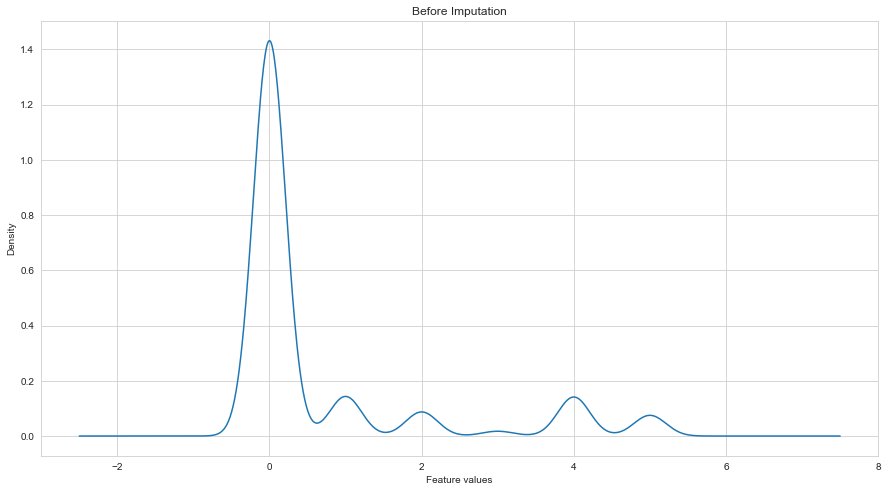

In [34]:
plt.figure(figsize = (15,8))
plt.title('Before Imputation')
plt.xlabel('Feature values')
df_pre['company_type'].plot(kind = 'kde')
plt.show()

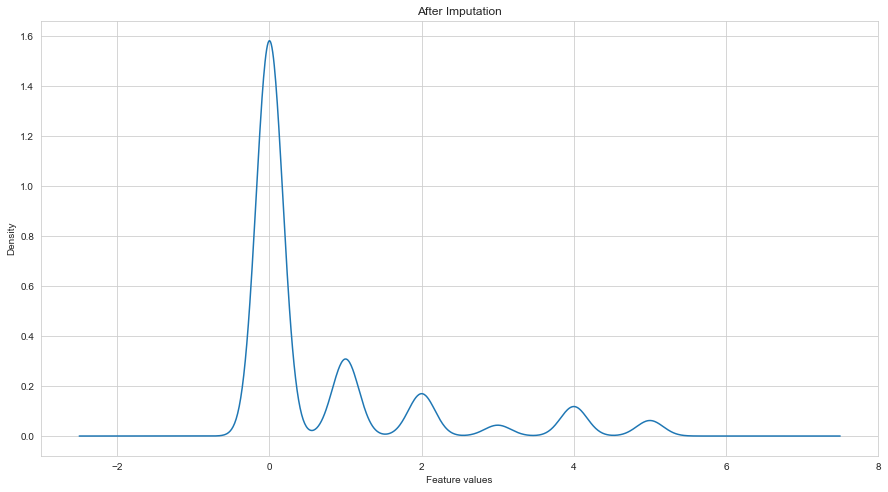

In [35]:
plt.figure(figsize = (15,8))
plt.title('After Imputation')
plt.xlabel('Feature values')
df_pre1['company_type'].plot(kind = 'kde')
plt.show()

In [36]:

missing_cols = df_pre.columns[df_pre.isna().any()].tolist()
missing_cols

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [37]:
#dataframe having features with missing values
df_missing = df_pre[['enrollee_id'] + missing_cols]

#dataframe having features without missing values
df_non_missing = df_pre.drop(missing_cols, axis = 1)

In [38]:
#k-Nearest Neighbour Imputation

knn_imputer = KNNImputer(n_neighbors = 3)

X = np.round(knn_imputer.fit_transform(df_missing))
#Rounding them because these are categorical features

df_missing = pd.DataFrame(X, columns = df_missing.columns)

In [39]:
#now lets join both dataframes 

df_pre2 = pd.merge(df_missing, df_non_missing, on = 'enrollee_id')

In [40]:
train = df_pre2[df_pre2['target'] != -1].reset_index(drop = True)
test = df_pre2[df_pre2['target'] == -1].reset_index(drop = True)

X = train.drop(['enrollee_id', 'target'], axis = 1)
Y = train['target']

# drop fake target feature from test data 
test = test.drop('target', axis = 1)

C:\Users\anant\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

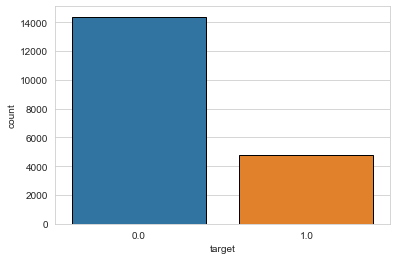

In [41]:
sns.countplot(train['target'], edgecolor = 'black')

## Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier

## change in test_train score with number of trees in random forest

In [78]:
train_score_tree = []
test_score_tree = []
for i in range(100,11000,200):
    clf = RandomForestClassifier(n_estimators = i)
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2 ,random_state = 42)
    clf.fit(X_train, y_train)
    train_score_tree.append(clf.score(X_train,y_train))
    test_score_tree.append(clf.score(X_val,y_val))
    print(i)

100
300
500
700
900
1100
1300
1500
1700
1900
2100
2300
2500
2700
2900
3100
3300
3500
3700
3900
4100
4300
4500
4700
4900
5100
5300
5500
5700
5900
6100
6300
6500
6700
6900
7100
7300
7500
7700
7900
8100
8300
8500
8700
8900
9100
9300
9500
9700
9900
10100
10300


KeyboardInterrupt: 

In [80]:
tree = []
for i in range(100,10400,200):
    tree.append(i)

In [89]:
tree = np.array(tree).reshape(52)
train_score_tree = np.array(train_score_tree).reshape(52)
test_score_tree = np.array(test_score_tree).reshape(52)

In [99]:
data = np.array([tree,train_score_tree,test_score_tree])

In [100]:
data = np.transpose(data)

In [102]:
data = pd.DataFrame(data,columns = ['tree','train_score_tree','test_score_tree'])

In [104]:
data.to_csv("train_test_score_number_of_trees.csv")

## changing max_depth

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2 ,random_state = 42)

In [111]:
train_score_depth = []
test_score_depth = []
for i in range(2,40,1):
    clf = RandomForestClassifier(n_estimators = 200,max_depth = i)
 
    clf.fit(X_train, y_train)
    train_score_depth.append(clf.score(X_train,y_train))
    test_score_depth.append(clf.score(X_val,y_val))
    print(i)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [112]:
depth = []
for i in range(2,40,1):
    depth.append(i)

In [113]:
data2 = np.array([depth,train_score_depth,test_score_depth])
data2 = np.transpose(data2)
data2 = pd.DataFrame(data2,columns = ['depth','train_score_depth','test_score_depth'])

In [117]:
data2.to_csv("train_test_score_max_depth.csv")

In [131]:
depth_choosen = 5

## changing max_leaf

In [132]:
train_score_leaf = []
test_score_leaf = []
for i in range(2,40,1):
    clf = RandomForestClassifier(n_estimators = 200,max_depth = depth_choosen,max_leaf_nodes =  i)
 
    clf.fit(X_train, y_train)
    train_score_leaf.append(clf.score(X_train,y_train))
    test_score_leaf.append(clf.score(X_val,y_val))
    print(i)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [133]:
leaf = []
for i in range(2,40,1):
    leaf.append(i)
data3 = np.array([depth,train_score_leaf,test_score_leaf])
data3 = np.transpose(data3)
data3 = pd.DataFrame(data3,columns = ['leaf','train_score_leaf','test_score_leaf'])

In [138]:
## no of leaves doesnt effect that much

In [59]:
num_trees = pd.read_csv("train_test_score_number_of_trees.csv")
max_depth = pd.read_csv("train_test_score_max_depth.csv")
max_leaf = pd.read_csv("train_test_score_max_leaf.csv")

In [60]:
del num_trees['Unnamed: 0']
del max_depth['Unnamed: 0']
del max_leaf['Unnamed: 0']

## Graph telling overfitting

Text(0.5, 1.0, 'Change in training score')

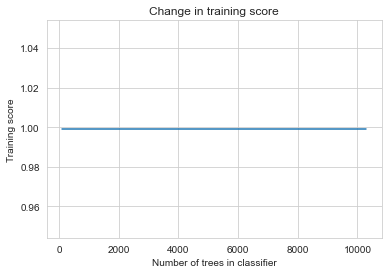

In [65]:
plt.plot(num_trees['tree'],num_trees['train_score_tree'])
plt.xlabel("Number of trees in classifier")
plt.ylabel("Training score")
plt.title('Change in training score') ## purely it is an overfitting example as training ascore is almost 1.
# CONCLUSION:- No matter what are the number of trees in forest at a particular the traininng score get constant

Text(0.5, 1.0, 'Change in testing score')

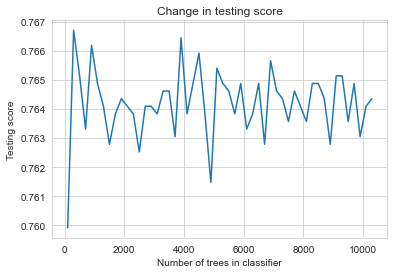

In [66]:
plt.plot(num_trees['tree'],num_trees['test_score_tree'])
plt.xlabel("Number of trees in classifier")
plt.ylabel("Testing score")
plt.title('Change in testing score') 
# As seen above the training score was approximately 1 (0 error) but we can see their are errors in testing set

Text(0.5, 1.0, 'train_score vs testing_score')

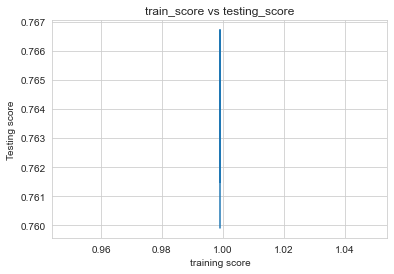

In [69]:
plt.plot(num_trees['train_score_tree'],num_trees['test_score_tree'])
plt.xlabel("training score")
plt.ylabel("Testing score")
plt.title('train_score vs testing_score') 
# here we can see that our model does overfitting giving minimum training error of 0.24 approx

## Solutions
### we can change the max _Depth ,max f we want or we can apply complexity parameter in our cost(PRUNING)

## score by variation in max_depth of the trees

Text(0.5, 1.0, 'Change in training score')

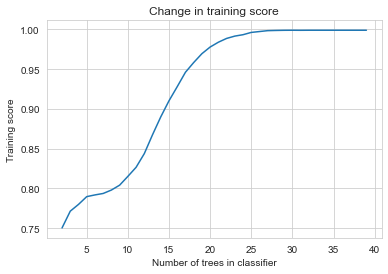

In [74]:
plt.plot(max_depth['depth'],max_depth['train_score_depth'])
plt.xlabel("Number of trees in classifier")
plt.ylabel("Training score")
plt.title('Change in training score') 
## hence giving max_depth performs good training set but as we keep on increasing max_depth it reaches where all nodes are pure 
#and complexity of tree is max so from the depth of 25 it start overfitiing and you will after depth = 25 testing set scores bad

Text(0.5, 1.0, 'Change in testing score')

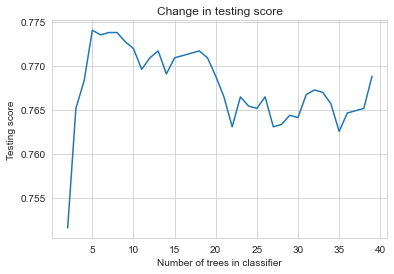

In [77]:
plt.plot(max_depth['depth'],max_depth['test_score_depth'])
plt.xlabel("Number of trees in classifier")
plt.ylabel("Testing score")
plt.title('Change in testing score')
# after depth of 25 testinfg score also scores bad 
# we can se nearly at the depth o 5 - 20 it our model is getting generalized and there is a slight improvement in testig score

In [78]:
## their is a ccp_alpha a tuning parameter multiplied with number of leaves is added to the cost so as to keep balnce between 
#cost and complexity of the model it is pruning. There are many more things to resolve the overfitting problems like feature selection ,bagging,etc